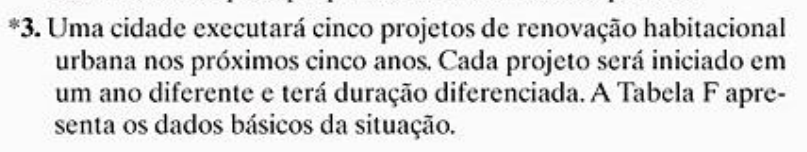

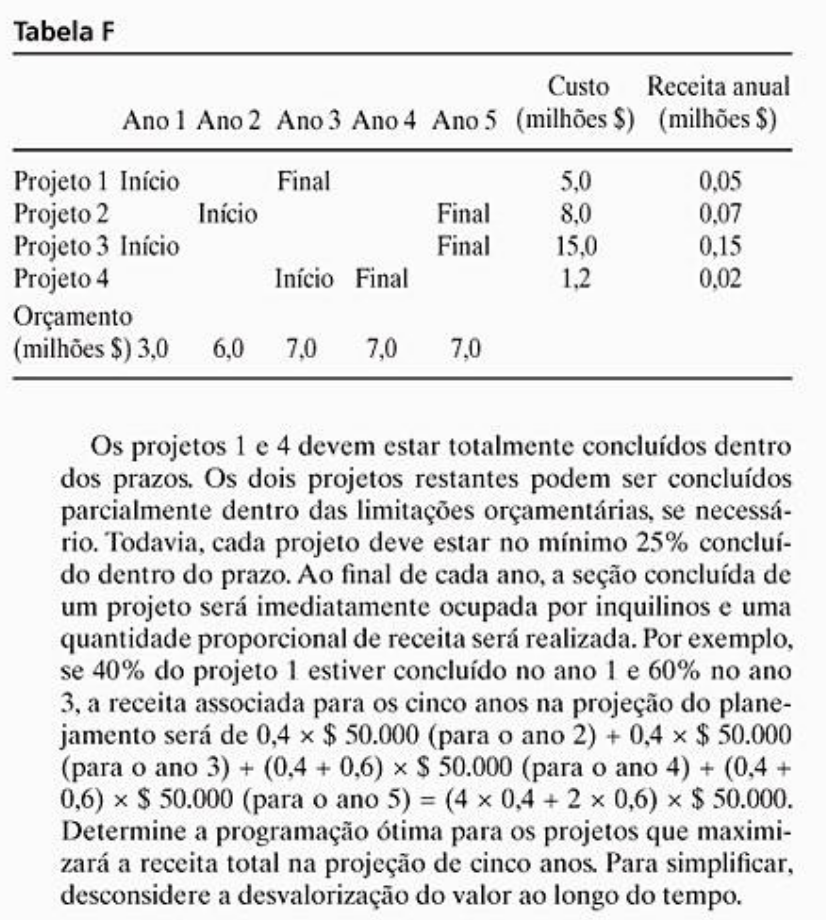

%pip install cplex
%pip install docplex

In [1]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Planejamento_Projetos_Renovacao')

In [2]:
# --- Parâmetros extraídos do enunciado e da Tabela F ---

# Identificadores
projetos = [1, 2, 3, 4]
anos = [1, 2, 3, 4, 5]

# Dados dos projetos
custo_total_proj = {1: 5.0, 2: 8.0, 3: 15.0, 4: 1.2}  # em milhões de $
receita_anual_proj = {1: 0.05, 2: 0.07, 3: 0.15, 4: 0.02} # em milhões de $
prazo_proj = {1: (1, 3), 2: (2, 5), 3: (1, 5), 4: (3, 4)} # (ano de início, ano de fim)

# Orçamento anual (em milhões de $)
orcamento_anual = {1: 3.0, 2: 6.0, 3: 7.0, 4: 7.0, 5: 7.0}

In [3]:
# 1. Variáveis de Decisão

# x(i,j) = fração do projeto i concluída no ano j (variáveis contínuas)
x = model.continuous_var_matrix(projetos, anos, name='x', lb=0)

# y(i) = 1 se o projeto i (2 ou 3) for parcialmente realizado, 0 caso contrário (binárias)
y = model.binary_var_dict([2, 3], name='y')


# 2. Função Objetivo
# Maximizar a receita total nos 5 anos (fórmula linearizada)
expressao_receita_total = (receita_anual_proj[i] *
                           (4*x[i,1] + 3*x[i,2] + 2*x[i,3] + x[i,4])
                           for i in projetos)
receita_total = model.sum(expressao_receita_total)
model.maximize(receita_total)


# 3. Restrições

# Restrição 1: Orçamento Anual
for j in anos:
    expressao_gasto_anual = (custo_total_proj[i] * x[i,j] for i in projetos)
    soma_gasto_anual = model.sum(expressao_gasto_anual)
    restr_orcamento_logica = soma_gasto_anual <= orcamento_anual[j]
    model.add_constraint(restr_orcamento_logica, ctname=f'orcamento_ano_{j}')

# Restrição 2: Conclusão dos Projetos
# Projetos 1 e 4 devem ser 100% concluídos
model.add_constraint(model.sum(x[1,j] for j in anos) == 1, ctname='conclusao_p1')
model.add_constraint(model.sum(x[4,j] for j in anos) == 1, ctname='conclusao_p4')

# Projetos 2 e 3 podem ser parcialmente concluídos (até 100%)
model.add_constraint(model.sum(x[2,j] for j in anos) <= 1, ctname='conclusao_parcial_p2')
model.add_constraint(model.sum(x[3,j] for j in anos) <= 1, ctname='conclusao_parcial_p3')

# Restrição 3: Prazos dos Projetos
# O trabalho em um projeto só pode ocorrer dentro de seu prazo
for i in projetos:
    inicio, fim = prazo_proj[i]
    for j in anos:
        if not (inicio <= j <= fim):
            model.add_constraint(x[i,j] == 0, ctname=f'prazo_p{i}_a{j}')

# Restrição 4: Mínimo de 25% de conclusão dentro do prazo
# Para projetos 1 e 4 (obrigatórios)
model.add_constraint(model.sum(x[1,j] for j in range(prazo_proj[1][0], prazo_proj[1][1] + 1)) >= 0.25, 'min_conclusao_p1')
model.add_constraint(model.sum(x[4,j] for j in range(prazo_proj[4][0], prazo_proj[4][1] + 1)) >= 0.25, 'min_conclusao_p4')

# Para projetos 2 e 3 (opcionais/parciais)
# Vincula a conclusão total à variável binária y
model.add_constraint(model.sum(x[2,j] for j in anos) <= y[2], 'vinculo_y2_a')
model.add_constraint(model.sum(x[3,j] for j in anos) <= y[3], 'vinculo_y3_a')
# Garante o mínimo de 25% SE o projeto for iniciado (y=1)
model.add_constraint(model.sum(x[2,j] for j in anos) >= 0.25 * y[2], 'vinculo_y2_b')
model.add_constraint(model.sum(x[3,j] for j in anos) >= 0.25 * y[3], 'vinculo_y3_b')

docplex.mp.LinearConstraint[vinculo_y3_b](x_3_1+x_3_2+x_3_3+x_3_4+x_3_5,GE,0.250y_3)

In [4]:
# Define um tempo limite para o solver (opcional)
model.parameters.timelimit = 120

# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
if solucao:
    receita_maxima = model.objective_value
    print(f"Receita Total Máxima em 5 anos: ${receita_maxima * 1_000_000:,.2f}")
    print("\n--- Programação Ótima de Conclusão (% por ano) ---")
    for i in projetos:
        conclusao_total = sum(x[i,j].solution_value for j in anos)
        if conclusao_total > 1e-6:
            print(f"\nProjeto {i} (Conclusão Total: {conclusao_total:.1%}):")
            for j in anos:
                fracao_ano = x[i,j].solution_value
                if fracao_ano > 1e-6:
                    print(f"  - Ano {j}: {fracao_ano:.1%}")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Found incumbent of value 0.202500 after 0.00 sec. (0.00 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 11 rows and 6 columns.
Aggregator did 1 substitutions.
Reduced MIP has 9 rows, 15 columns, and 37 nonzeros.
Reduced MIP has 2 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 9 rows, 15 columns, and 37 nonzeros.
Reduced MIP has 2 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.02 ticks)
Probing time = 0.00 sec. (0.00 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 16 threads.
Root relaxation solution time = 0.00 sec. (0.02 ticks)

        No